In [1]:
#参考博客https://www.cnblogs.com/alterwl/p/15795369.html
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy import stats
import sys
from pathlib import Path
# 保证绝对路径可以被检测到
# sys.path.append('E:\Lab\TEP-KG') # 将项目根目录添加到 
sys.path.append("\\".join(sys.path[0].split("\\")[:-1]))
from utils.tep_nmi import tep_dataset_read

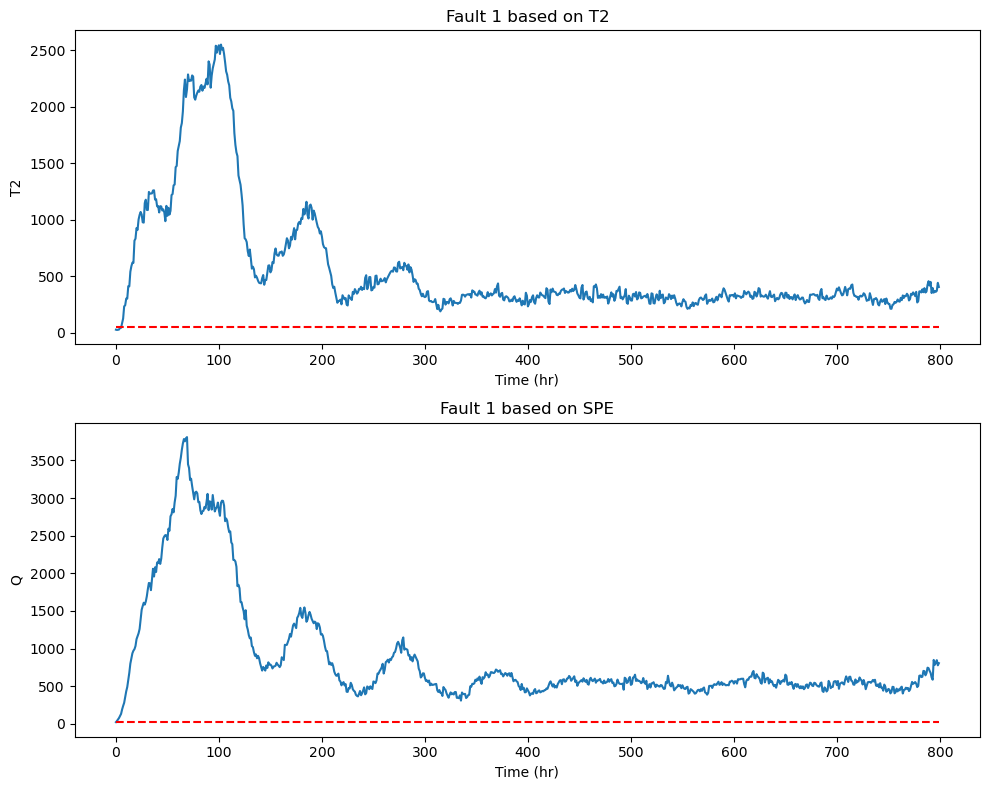

In [18]:
#参数设置
id_test = 300 #贡献图选择位置（相对于test集合的位置）
num_pc = 22 #设置为0时就按照累积贡献率（PCA_components_rate）计算num_pc,不为0就按照这里的设置算
PCA_components_rate = 0.9
confidence_T2UCL = 0.99 
confidence_QUCL = 0.99

#数据集读取
train_path = '../data/TEP-dataset/train/d01.dat'
test_path = '../data/TEP-dataset/test/d01_te.dat'
tdr = tep_dataset_read()
Xtrain = tdr.tep_dataset_read(train_path).transpose()
Xtest = tdr.tep_dataset_read(test_path).transpose()

#采用160组正常数据建立主元分析故障诊断模型,计算使系统稳定运行的控制限，对每种故障分别采用800组故障数据进行故障诊断测试
Xtrain = Xtest[:160]
Xtest= Xtest[160:]

# 计算每一列的平均值
X_mean = np.mean(Xtrain, axis=0) 
# 计算每一列的标准差,这里python一般算总体标准差吗，matlab算样本标准差
X_std = np.std(Xtrain, axis=0,ddof=1) 
# 检查X_train的行数和列数
X_row, X_col = Xtrain.shape 
# 将Xtrain标准化
Xtrain_standard = (Xtrain - np.tile(X_mean, (X_row, 1)))/np.tile(X_std, (X_row, 1)) 

#求协方差矩阵
sigmaXtrain = np.cov(Xtrain_standard.transpose())
#求特征值和特征向量矩阵
eigenValues,eigenVectors = np.linalg.eig(sigmaXtrain)
#根据特征值从大到小顺序排序，特征向量矩阵以此排序
idx = eigenValues.argsort()
eigenValues = eigenValues[idx]
eigenVectors = eigenVectors[:,idx]
#lamda为特征值构成的对角阵
lamda = np.diag(eigenValues)
#T的列为单位特征向量，且与lamda中的特征值一一对应：
T = eigenVectors
#从大到小排列的特征值序列
D= eigenValues[::-1]

#主元个数初值为1，若累计贡献率小于PCA_components_rate(90%)则增加主元个数
if num_pc==0:#没设置num_pc就按照累积贡献率算主成分数量
    num_pc = 1
    while sum(D[:num_pc]/sum(D))<PCA_components_rate:
        num_pc+=1
#取与lamda相对应的特征向量,即取T的后num_pc列特征向量,对应最大那一组的特征值
P = T[:,X_col-num_pc:X_col]

#求置信度为confidence_T2UCL(99%)时的T2统计控制限
# f分布函数用来计算F分布的概率密度函数(PDF),而f.ppf计算累积概率为confidence_T2UCL(0.99)的逆累积分布函数值(ICDF)
T2UCL=num_pc*(X_row-1)*(X_row+1)*stats.f.ppf(confidence_T2UCL,num_pc,X_row - num_pc)/(X_row*(X_row - num_pc))

#置信度为confidence_QUCL(99%)的Q统计控制限，也称为平方预报误差（Squared Prediction Error, SPE）
theta = []
for i in range(0,3):
    theta.append(sum(D[num_pc:X_col]**(i+1)))
h0 = 1 - 2*theta[0]*theta[2]/(3*theta[1]**2)
#norm.ppf方法用于计算标准正态分布的逆累积分布函数（ICDF）
ca = stats.norm.ppf(confidence_QUCL)
QUCL = theta[0]*(h0*ca*np.sqrt(2*theta[1])/theta[0] + 1 + theta[1]*h0*(h0 - 1)/theta[0]**2)**(1/h0)

#在线监测
#标准化处理
n = Xtest.shape[0]
Xtest_standard=(Xtest-np.tile(X_mean,(n,1)))/np.tile(X_std,(n,1))

#求T2统计量，Q统计量
r, y = np.dot(P,P.transpose()).shape
I = np.eye(r, y)
T2 = np.zeros([n,1])
Q = np.zeros([n,1])
for i in range(n):
    T2[i]=np.dot(np.dot(np.dot(np.dot(Xtest_standard[i,:],P),np.linalg.inv(lamda[X_col-num_pc:X_col,X_col-num_pc:X_col])),P.transpose()),Xtest_standard[i,:].transpose())
    Q[i] = np.dot(np.dot(Xtest_standard[i,:],[I - np.dot(P,P.transpose())]),Xtest_standard[i,:].transpose())

#绘制T2与Q的统计量图
plt.figure(figsize=(10,8))
t = np.arange(0, n)

plt.subplot(2,1,1)
plt.plot(t, T2)
plt.ylabel('T2')
plt.xlabel('Time (hr)')
plt.title('Fault 1 based on T2')
plt.plot(t, np.ones((n, 1)) * T2UCL, 'r--')

plt.subplot(2,1,2)
plt.plot(t, Q)
plt.ylabel('Q')
plt.xlabel('Time (hr)')
plt.title('Fault 1 based on SPE')
plt.plot(t, np.ones((n, 1)) * QUCL, 'r--')

plt.tight_layout()
plt.savefig('pca_fig/T2_Q_chart.png', dpi=300, format='png')
plt.show()

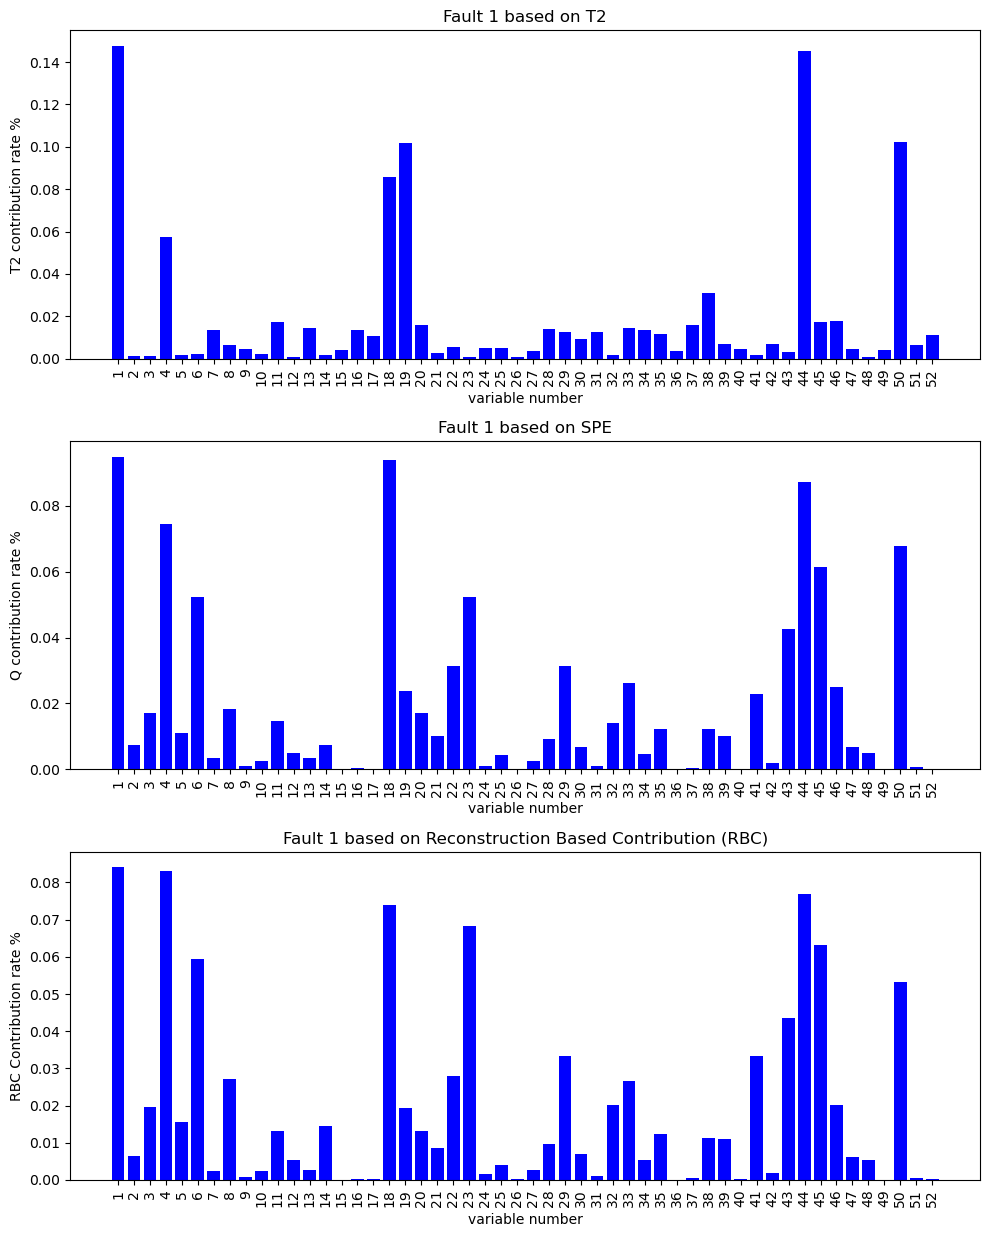

In [19]:
#贡献图

#T2贡献图
#1.确定造成失控状态的得分
S = np.dot(Xtest_standard[id_test,:],P[:,:num_pc])
r = []
for i in range(num_pc):
    # if S[i]**2/lamda[0][i] > T2UCL/num_pc: 网上的写法，我感觉是错的，应该除的是特征值
    if S[i]**2/sum(lamda[i]) > T2UCL/num_pc:
        r.append(i)

#2.计算每个变量相对于上述失控得分的贡献
cont = np.zeros([len(r),X_col])
for i in range(len(r)):
    for j in range(X_col):
        temp = np.abs(S[r[i]]/D[r[i]]*P[j][r[i]]*Xtest_standard[id_test][j])
        if temp<0:
            temp=0
        cont[i][j] = temp

#3.计算每个变量的总贡献
CONTJ = np.zeros([X_col,1])
for j in range(X_col):
    CONTJ[j] = sum(cont[:,j])

#SPE贡献图
#计算每个变量对Q的贡献
e = np.dot(Xtest_standard[id_test,:],[I - np.dot(P,P.transpose())])
CONTQ = e**2

#RBC贡献图
#按照RBC-SPE公式算
CONTRBC = np.zeros([X_col])
for i in range(0,len(CONTQ.flatten())):
    CONTRBC[i] = CONTQ.flatten()[i]/(I - np.dot(P,P.transpose()))[i][i]

#绘制贡献图
plt.figure(figsize=(10,12))
variable_names = [f'{i+1}' for i in range(X_col)]

plt.subplot(3,1,1)
plt.bar(variable_names, CONTJ.flatten()/np.sum(CONTJ), color='blue')
plt.xticks(rotation=90)
plt.xlabel('variable number')
plt.ylabel('T2 contribution rate %')
plt.title('Fault 1 based on T2')

plt.tight_layout()
plt.subplot(3,1,2)
plt.bar(variable_names, CONTQ.flatten()/np.sum(CONTQ), color='blue')
plt.xticks(rotation=90)
plt.xlabel('variable number')
plt.ylabel('Q contribution rate %')
plt.title('Fault 1 based on SPE')

plt.tight_layout()
plt.subplot(3,1,3)
plt.bar(variable_names, CONTRBC/np.sum(CONTRBC), color='blue')
plt.xticks(rotation=90)
plt.xlabel('variable number')
plt.ylabel('RBC Contribution rate %')
plt.title('Fault 1 based on Reconstruction Based Contribution (RBC)')

plt.savefig('pca_fig/T2_Q_contribution_chart.png', dpi=300, format='png')
plt.show()

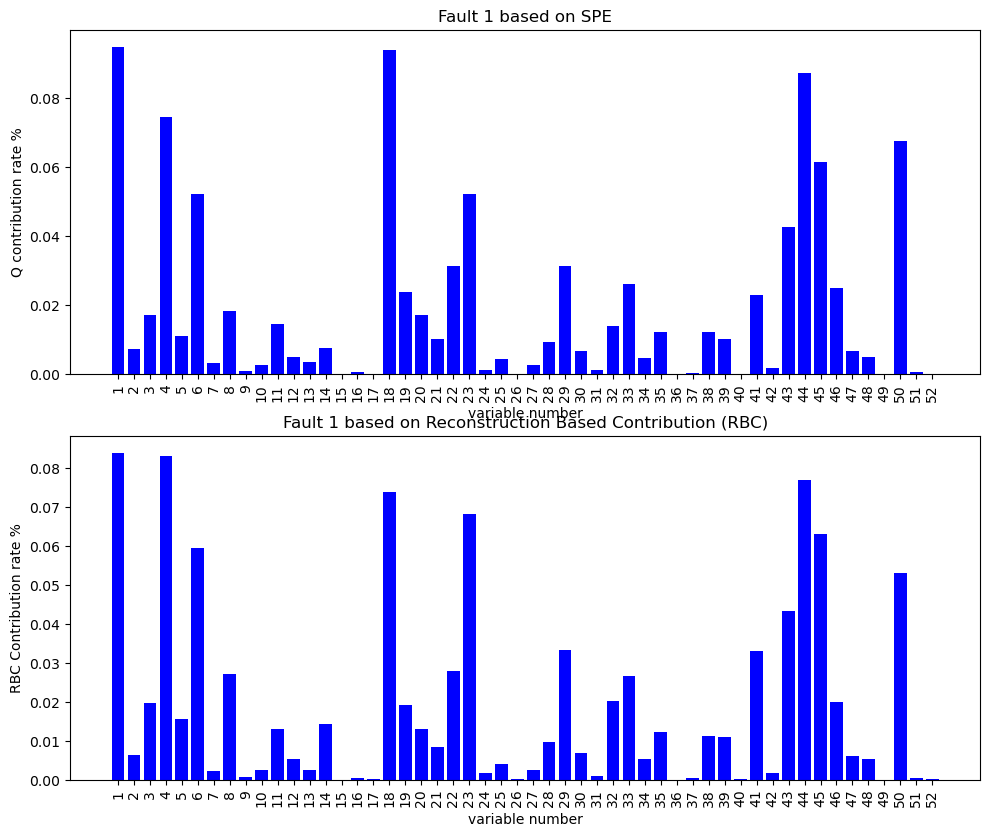

In [20]:
# 按照sklearn库函数计算
#pca
pca = PCA(n_components=num_pc) # 创建PCA对象，可以指定n_components，即要保留的主成分数量
pca.fit(Xtrain_standard) #拟合正常数据

#spe contribution
Xtest_standard_pca = pca.transform(Xtest_standard) # 异常数据转换数据到主成分空间
loadings = pca.components_.T # 计算载荷
reconstructed_Xtest_standard_pca = pca.inverse_transform(Xtest_standard_pca ) # 重构数据
reconstruction_error = np.abs(Xtest_standard - reconstructed_Xtest_standard_pca)**2 # 计算重构误差
spe_contributions = reconstruction_error[id_test] # 计算每个变量的SPE贡献

#rbc contribution
rbc_contributions = np.zeros([len(spe_contributions)])
for i in range(0,len(spe_contributions)):
    rbc_contributions[i] = spe_contributions[i]/(I - np.dot(loadings,loadings.transpose()))[i][i]

#绘制贡献图
plt.figure(figsize=(10,8))
variable_names = [f'{i+1}' for i in range(X_col)]

plt.tight_layout()
plt.subplot(2,1,1)
plt.bar(variable_names, spe_contributions.flatten()/np.sum(spe_contributions), color='blue')
plt.xticks(rotation=90)
plt.xlabel('variable number')
plt.ylabel('Q contribution rate %')
plt.title('Fault 1 based on SPE')

plt.tight_layout()
plt.subplot(2,1,2)
plt.bar(variable_names, rbc_contributions/np.sum(rbc_contributions), color='blue')
plt.xticks(rotation=90)
plt.xlabel('variable number')
plt.ylabel('RBC Contribution rate %')
plt.title('Fault 1 based on Reconstruction Based Contribution (RBC)')

plt.savefig('pca/pca_fig/T2_Q_contribution_sklearn_chart.png', dpi=300, format='png')
plt.show()